![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de modelos Bagging, Random Forest y XGBoost

En este taller podrán poner en práctica sus conocimientos sobre la construcción e implementación de modelos de Bagging, Random Forest y XGBoost. El taller está constituido por 8 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción precio de automóviles

En este taller se usará el conjunto de datos de Car Listings de Kaggle donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como año, marca, modelo, entre otras. El objetivo es predecir el precio del automóvil. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

In [87]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
# Importación de librerías
%matplotlib inline
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
# Lectura de la información de archivo .csv
data = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/dataTrain_carListings.zip')

# Preprocesamiento de datos para el taller
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data = data.drop(['Model'], axis=1)

# Visualización dataset
data.head()

,Price,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE
7,21995,2014,6480,False,False,False,True,False,False,False
11,13995,2014,39972,False,False,False,False,True,False,False
167,17941,2016,18989,False,False,False,False,False,True,False
225,12493,2014,51330,False,False,False,True,False,False,False
270,7994,2007,116065,False,True,False,False,False,False,False


In [3]:
# Separación de variables predictoras (X) y variable de interés (y)
y = data['Price']
X = data.drop(['Price'], axis=1)

In [4]:
# Separación de datos en set de entrenamiento y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Punto 1 - Árbol de decisión manual

En la celda 1 creen un árbol de decisión **manualmente**  que considere los set de entrenamiento y test definidos anteriormente y presenten el RMSE y MAE del modelo en el set de test.

In [ ]:
# Celda 1


### Punto 2 - Bagging manual

En la celda 2 creen un modelo bagging **manualmente** con 10 árboles de regresión y comenten sobre el desempeño del modelo.

In [ ]:
# Celda 2


### Punto 3 - Bagging con librería

En la celda 3, con la librería sklearn, entrenen un modelo bagging con 10 árboles de regresión y el parámetro `max_features` igual a `log(n_features)` y comenten sobre el desempeño del modelo.

In [ ]:
# Celda 3


### Punto 4 - Random forest con librería

En la celda 4, usando la librería sklearn entrenen un modelo de Randon Forest para regresión  y comenten sobre el desempeño del modelo.

In [85]:
# Celda 4
#Modelo Random Forest
rfr=RandomForestRegressor(random_state=2,n_jobs=-1)
# Entrenar el modelo
rfr.fit(X_train,y_train)
# Predicción
y_pred_rfr=rfr.predict(X_test)
# Evaluación del modelo
mse_rfr=mean_squared_error(y_test,y_pred_rfr)
# MSE del modelo Random Forest
print(f'MSE del Random Forest: {mse_rfr:,.0f}')


MSE del Random Forest: 3,093,056


### Punto 5 - Calibración de parámetros Random forest

En la celda 5, calibren los parámetros max_depth, max_features y n_estimators del modelo de Randon Forest para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

#### N_ESTIMATORS

In [69]:
# Celda 5
n_estimators = range(10,560,50)
mse_scores_estimatores = []

for n in n_estimators:
    rfr=RandomForestRegressor(n_estimators=n,random_state=2,n_jobs=-1)
    mse_scores_estimatores.append(cross_val_score(rfr,X_train,y_train,cv=5,scoring='neg_mean_squared_error').mean())

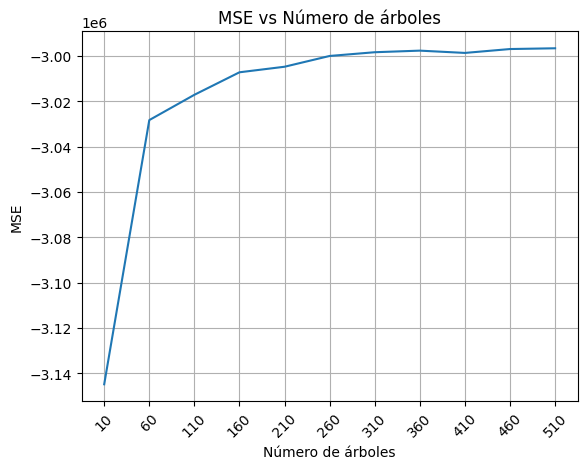

In [77]:
# Gráfica de MSE vs n_estimators
plt.plot(n_estimators,mse_scores_estimatores)
plt.xlabel('Número de árboles')
plt.ylabel('MSE')
plt.title('MSE vs Número de árboles')
plt.xticks(n_estimators,rotation=45)
plt.grid(True)
plt.show()

360 estimadores parece ser una muy buena opción, aunque después de este numero se obtienen mejoras graduales, no es tan sifinificativo el aumento del mse.

In [81]:
rfr=RandomForestRegressor(n_estimators=360,random_state=4,n_jobs=-1)
rfr.fit(X_train,y_train)
# Predicción
y_pred_rfr_estimators=rfr.predict(X_test)
# Evaluación del modelo
mse_rfr_n_estimators=mean_squared_error(y_test,y_pred_rfr_estimators)
# MSE del modelo Random Forest con el número óptimo de árboles y variables
print(f'MSE del Random Forest optimizado con estimadores: {mse_rfr_n_estimators:,.0f}')

MSE del Random Forest optimizado con estimadores: 3,080,171


#### MAX_FEATURES

In [71]:
feature_range = range(1, X.shape[1]+1)
mse_scores_features = []
for feature in feature_range:
    rfr=RandomForestRegressor(n_estimators=360,max_features=feature,random_state=3,n_jobs=-1)
    mse_scores_features.append(cross_val_score(rfr,X_train,y_train,cv=5,scoring='neg_mean_squared_error').mean())

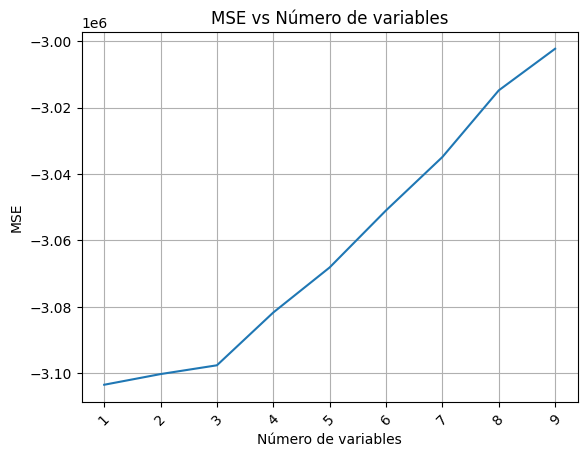

In [76]:
# Gráfica de MSE vs n_estimators
plt.plot(feature_range,mse_scores_features)
plt.xlabel('Número de variables')
plt.ylabel('MSE')
plt.title('MSE vs Número de variables')
plt.xticks(feature_range,rotation=45)
plt.grid(True)
plt.show()

In [82]:
rfr=RandomForestRegressor(n_estimators=360,max_features=9,random_state=4,n_jobs=-1)
rfr.fit(X_train,y_train)
# Predicción
y_pred_rfr_features=rfr.predict(X_test)
# Evaluación del modelo
mse_rfr_features=mean_squared_error(y_test,y_pred_rfr_features)
# MSE del modelo Random Forest con el número óptimo de árboles y variables
print(f'MSE del Random Forest optimizado: estimadores y features: {mse_rfr_features:,.0f}')

MSE del Random Forest optimizado: estimadores y features: 3,080,171


#### MAX_DEPTH

In [ ]:
depths = range(2, 22, 2)
mse_scores_depths = []

for d in depths:
    rfr = RandomForestRegressor(n_estimators=360, max_features=9, max_depth=d, random_state=5, n_jobs=-1)
    mse_scores_depths.append(cross_val_score(rfr,X_train,y_train,cv=5,scoring='neg_mean_squared_error').mean())

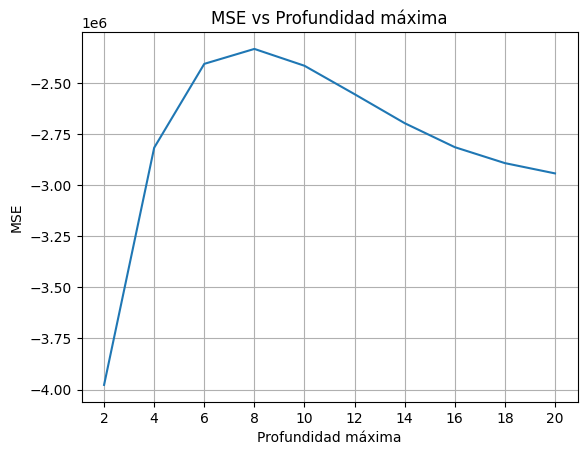

In [75]:
# Gráfica de MSE vs max_depth
plt.plot(depths, mse_scores_depths)
plt.xlabel('Profundidad máxima')
plt.ylabel('MSE')
plt.title('MSE vs Profundidad máxima')
plt.xticks(depths)
plt.grid(True)
plt.show()

In [83]:
# Entrenar el modelo con el número óptimo de árboles y variables
rfr=RandomForestRegressor(n_estimators=360,max_features=9,max_depth=8,random_state=4,n_jobs=-1)
rfr.fit(X_train,y_train)
# Predicción
y_pred_rfr_best=rfr.predict(X_test)
# Evaluación del modelo
mse_tree_reg_best=mean_squared_error(y_test,y_pred_rfr_best)
# MSE del modelo Random Forest con el número óptimo de árboles y variables
print(f'MSE del Random Forest optimizado:estimadores, features, max_depth {mse_tree_reg_best:,.0f}')

MSE del Random Forest optimizado:estimadores, features, max_depth 2,452,662


In [89]:
# Grilla de hiperparámetros
param_grid = {
    'n_estimators': [100, 200, 360],
    'max_depth': [4, 8, 10],
    'max_features': [3, 6, 9]
}
# Modelo Random Forest
rfr = RandomForestRegressor(random_state=7, n_jobs=-1)
# Búsqueda con validación cruzada usando GridSearchCV
grid_search = GridSearchCV(estimator=rfr, param_grid=param_grid,
                           scoring='neg_mean_squared_error',
                           cv=5, n_jobs=-1, verbose=1)
# Entrenamiento
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(n_jobs=-1, random_state=7),
             n_jobs=-1,
             param_grid={'max_depth': [4, 8, 10], 'max_features': [3, 6, 9],
                         'n_estimators': [100, 200, 360]},
             scoring='neg_mean_squared_error', verbose=1)

In [90]:
# Resultados
print("Mejores parámetros:", grid_search.best_params_)
print(f"Mejor MSE promedio: {grid_search.best_score_:,.0f}")

Mejores parámetros: {'max_depth': 8, 'max_features': 6, 'n_estimators': 360}
Mejor MSE promedio: -2,308,534


| Hiperparámetro | Efecto sobre el modelo | Nota |
|----------------|------------------------|----------------------|
| `n_estimators` | Mayor cantidad de estimaodres mejora el desempeño del modelo aunque no considerablemente. | mejoras leves pero consistentes. |
| `max_features` | Entrenear este parameetro sin contemplar todas las caombinaciones de hiperparámetros arroja resultados locasles | `max_features=6` es el óptimo dado por Grid Search |
| `max_depth`    | Limitar la profunidad ayuda a no tener sobreajuste y obtener mejroes resultados | Este hiperparámetro ayudó a mejorar mucho el resultado del modelo |

El orden de optimización de hiperparámetros puede ser relevante, pero aún más relevante es tener las combinaciones de posibles hiperparámetros, puesto que la optimización local de 1 solo puede no ser la mejor opción para las siguientes iteraciones

### Punto 6 - XGBoost con librería

En la celda 6 implementen un modelo XGBoost de regresión con la librería sklearn y comenten sobre el desempeño del modelo.

In [ ]:
# Celda 6


### Punto 7 - Calibración de parámetros XGBoost

En la celda 7 calibren los parámetros learning rate, gamma y colsample_bytree del modelo XGBoost para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

In [ ]:
# Celda 7


### Punto 8 - Comparación y análisis de resultados
En la celda 8 comparen los resultados obtenidos de los diferentes modelos (random forest y XGBoost) y comenten las ventajas del mejor modelo y las desventajas del modelo con el menor desempeño.

In [ ]:
# Celda 8
